In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
from functools import partial

In [4]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm, trange
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader, random_split, Subset
from IPython.display import clear_output
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

In [5]:
from lared_laughter.fusion.dataset.segmentation import SegmentationDataset
from lared_laughter.audio.dataset import AudioLaughterExtractor
from lared_laughter.audio.audio_utils import featurize_melspec
from lared_laughter.accel.dataset import AccelExtractor
from lared_laughter.constants import dataset_path, datasets_path
from lared_laughter.accel.models.resnet import SegmentationResnet
from lared_laughter.video.dataset.extractor import VideoExtractor
from lared_laughter.video.dataset.transforms import get_kinetics_val_transform

In [6]:
examples = pd.read_csv(os.path.join(dataset_path, 'computational_examples.csv'))
# examples = examples[examples['condition'] == 'video'].reset_index()

## Plotting a few examples

In [7]:
extractors={}
accel_ds_path = os.path.join(dataset_path, 'accel_long.pkl')
extractors['accel'] = {
    'extractor': AccelExtractor(accel_ds_path, min_len=60), 
    'id_column': 'hash'
}

audios_path = os.path.join(datasets_path, "loose", "lared_audios.pkl")
extractors['audio'] = {
    'extractor': AudioLaughterExtractor(audios_path), 
    'id_column': 'hash'
}

videos_path = os.path.join(datasets_path, 'loose', 'video')
extractors['video'] = {
    'extractor': VideoExtractor(videos_path,
        transform=get_kinetics_val_transform(32, 256, True)), 
    'id_column': 'hash'
}

annot_path = os.path.join(dataset_path, 'continuous.pkl')
ds = SegmentationDataset(examples, annot_path, extractors, 
    window_len=90,
    resize_len=60)
raw_ds = SegmentationDataset(examples, annot_path, extractors)

In [8]:
type(ds[0]['video'])

list

In [7]:
ds[0]['video'][0].shape, ds[0]['video'][1].shape

(torch.Size([3, 8, 256, 256]), torch.Size([3, 32, 256, 256]))

In [8]:
from lared_laughter.utils import plot_accel, plot_audio

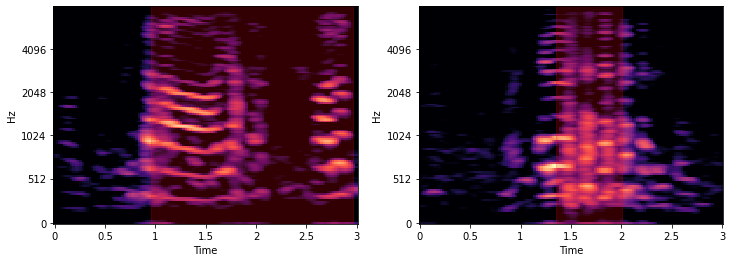

In [9]:
plot_audio([ds[786], ds[786]])

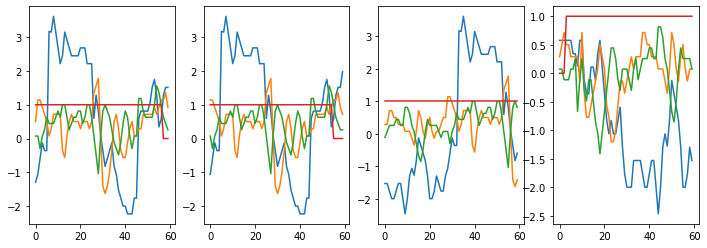

In [10]:
plot_accel([ds[786] for i in range(4)])

### verification of the ds

In [11]:
for i in trange(len(ds)):
    d = ds[i]
    if 'accel' in d:
        assert d['accel'].shape[1] == 60, str(d['accel'].shape)
    if 'audio' in d:
        assert d['audio'].shape[1] == 130, str(d['audio'].shape)
    if 'video' in d:
        assert d['video'][0].shape[1] == 8, str(d['video'][0].shape)
        assert d['video'][1].shape[1] == 32, str(d['video'][1].shape)

  0%|          | 0/2016 [00:00<?, ?it/s]

In [ ]:
class System(pl.LightningModule):
    def __init__(self, modality):
        super().__init__()
        self.modality = modality

        if modality == 'accel':
            self.model = SegmentationResnet(3, 1)

    def forward(self, batch):
        return self.model(batch[self.modality])

    def training_step(self, batch, batch_idx):
        out_proba, out_segmentation = self.model(batch[self.modality])

        out_segmentation = out_segmentation.squeeze()
        loss = F.binary_cross_entropy_with_logits(out_segmentation, batch['seg_mask'])

        # Logging to TensorBoard by default
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=.001)
        return optimizer

    def validation_step(self, batch, batch_idx):
        out_proba, out_segmentation = self.model(batch[self.modality])
        out_segmentation = out_segmentation.squeeze()
        val_loss = F.binary_cross_entropy_with_logits(out_segmentation, batch['seg_mask'])
        self.log('val_loss', val_loss)

        return (out_segmentation, batch['seg_mask'])

    def validation_epoch_end(self, validation_step_outputs):
        all_outputs = torch.cat([o[0] for o in validation_step_outputs]).cpu()
        all_masks = torch.cat([o[1] for o in validation_step_outputs]).cpu()

        output_masks = (torch.nn.functional.sigmoid(all_outputs) > 0.5).int()

        val_acc = torch.sum(output_masks == all_masks) / all_masks.numel()
        val_loss = F.binary_cross_entropy_with_logits(all_outputs, all_masks)
        self.log('val_acc', val_acc)
        self.log('val_loss', val_loss)

    def test_step(self, batch, batch_idx):
        out_proba, out_segmentation = self.model(batch[self.modality])
        out_segmentation = out_segmentation.squeeze()

        return (out_segmentation, batch['seg_mask'])

    def test_epoch_end(self, test_step_outputs):
        all_outputs = torch.cat([o[0] for o in test_step_outputs]).cpu()
        all_masks = torch.cat([o[1] for o in test_step_outputs]).cpu()

        output_masks = (torch.nn.functional.sigmoid(all_outputs) > 0.5).int()

        test_acc = torch.sum(output_masks == all_masks) / all_masks.numel()
        test_loss = F.binary_cross_entropy_with_logits(all_outputs, all_masks)
        self.test_results = {'acc': test_acc, 'loss': test_loss}
        self.log('test_acc', test_acc)
        self.log('test_loss', test_loss)

In [ ]:
def do_fold(train_ds, test_ds, modality, trainer_params={}, log_prefix=None):
    # data loaders
    data_loader_train = torch.utils.data.DataLoader(
        train_ds, batch_size=100, shuffle=True, num_workers=10,
        collate_fn=None)
    data_loader_val = torch.utils.data.DataLoader(
        test_ds, batch_size=100, shuffle=False, num_workers=10,
        collate_fn=None)

    system = System(modality)
    trainer_fn = partial(pl.Trainer, **trainer_params)
    trainer = trainer_fn(
        callbacks=[EarlyStopping(monitor="val_loss", mode="min")] + trainer_params.get('callbacks', []),
        accelerator='gpu',
        log_every_n_steps=1,
        max_epochs=-1,
        logger= pl.loggers.TensorBoardLogger(
            save_dir='logs/', name='fuse', version=log_prefix+'_fusion' if log_prefix else None),
        enable_checkpointing=False)
    trainer.fit(system, data_loader_train, data_loader_val)

    trainer.test(system, data_loader_val)
    return system.test_results

In [ ]:
def do_cross_validation(ds, modality, log_prefix=None):
    seed = 22
    cv_splits = KFold(n_splits=4, random_state=seed, shuffle=True).split(range(len(ds)))

    run_metrics = []
    for f, (train_idx, test_idx) in enumerate(cv_splits):
        # create dss    
        train_ds = Subset(ds, train_idx)
        test_ds = Subset(ds, test_idx)

        fold_metrics = do_fold(train_ds, test_ds, modality,
            log_prefix=log_prefix+f'fold{f}' if log_prefix else None)
        run_metrics.append(fold_metrics)
        clear_output(wait=True)

    return run_metrics

## Training

In [ ]:
res = {}
for input_modality in ['accel']:
    input_modality_res = {}

    for label_modality in ['audio', 'video', 'av']:

        filtered_examples = examples[examples['condition'] == label_modality].reset_index()

        # create the feature datasets
        extractors = {}
        if 'audio' == input_modality:
            extractors['audio'] = SwitchBoardLaughterDataset(
                df=examples,
                audios=audios,
                feature_fn=partial(featurize_melspec, hop_length=186),
                sr=8000,
                subsample_length=1.0,
                id_column='hash',
                label_column='pressed_key')
            # extractors['audio'] = FeatureDataset('../audio/features/resnet_bigger.pkl', 
            #     key="resnet_bigger_bn2")
        if 'video' == input_modality:
            pass
            # extractors['video'] = FeatureDataset('../video/features/slowfast_test.pkl',
            #     key="proj_input")
        if 'accel' == input_modality:
            accel_ds_path = os.path.join(dataset_path, 'accel_long.pkl')
            extractors['accel'] = {
                'extractor': AccelExtractor(accel_ds_path, min_len=60), 
                'id_column': 'hash'
            }
        annot_path = os.path.join(dataset_path, 'continuous.pkl')
        extractors['seg_mask'] = {
            'extractor': LabelExtractor(annot_path, min_len=90),
            'id_column': lambda x: (x['hit_id'], x['hash'], x['condition'])
        }
        subsampler = Subsample(90, 60)

        ds = FatherDataset(examples, extractors, transform=subsampler)
        
        input_modality_res[label_modality] = []
        for i in range(1):
            metrics = do_cross_validation(ds, 
                modality=input_modality,
                log_prefix=f'({input_modality})L({label_modality})_run{i}')
            input_modality_res[label_modality].append(metrics)
            torch.cuda.empty_cache()

    res[input_modality] = input_modality_res

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type               | Params
---------------------------------------------
0 | model | SegmentationResnet | 516 K 
---------------------------------------------
516 K     Trainable params
0         Non-trainable params
516 K     Total params
2.067     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6199735403060913
        test_loss           0.8085299141116752
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
